# Proyecto QvaPay

## Introducción

##### El proyecto se estructura en 4 pasos:
- Acceso a la API, descarga de la información y conformación del dataframe básico.
- Comentario sobre las distintas funciones usadas en la estadística.
-  

### Paquetes usados

In [2]:
import pandas as pd
from pandas import json_normalize
import json
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from collections import Counter
import numpy as np
import requests
import time

import warnings
warnings.filterwarnings('ignore')


### Acceso a la API

Autenticación y obtención del token de acceso a la API

In [10]:
correo = input('Correo:')
contraseña = input('contraseña:')
# URL del endpoint para la autenticación
login_url = "https://qvapay.com/api/auth/login"  

# Datos para la autenticación, que incluirían tus credenciales (usuario y contraseña)
login_data = {
    "email": f"{correo}",        # Correo de usuario de acceso
    "password": f"{contraseña}"           # Contraseña de usuario de acceso
}

# Realizar la solicitud POST al endpoint de autenticación
login_response = requests.post(login_url, json=login_data)

# Verificar si la autenticación fue exitosa
if login_response.status_code == 200:
    # Extraer el token de acceso
    login_data = login_response.json()  # Dependiendo de la respuesta
    access_token = login_data.get("accessToken")  # Aquí puede ser otro campo según la API

    print("Autenticado exitosamente, token recibido:", access_token)
else:
    print("Error en la autenticación:", login_response.status_code)


# Definir las cabeceras, incluyendo el token de autenticación
headers = {
    "Authorization": f"Bearer {access_token}"
}


#### Guardar la data en un archivo Json. 

Aquí, producto de errores 429, puse un contador aleatorio de tiempo para volver a hacer request

In [ ]:
# URL base del endpoint de la API (sólo para primera página)
base_url = "https://qvapay.com/api/p2p/index"  # Cambia con el URL correcto de la API

# Inicializamos la lista para guardar todos los datos obtenidos
all_data = []

# Realizamos la primera solicitud (si no tienes un `next` desde la respuesta, simplemente solicita la primera página)
url = base_url
print(url)

retry_attempts = 0  # Intentos de reintentos en caso de error 429
max_retries = 5     # Máximo número de reintentos antes de abortar


while url:
    # Realizamos la solicitud GET a la API
    response = requests.get(url, headers=headers)
    time.sleep(np.random.randint(2)) 
    if response.status_code == 200:
        # Extraemos los datos de la respuesta
        page_data = response.json()
        
        # Aquí 'data' será el campo donde vienen los datos de cada página
        all_data.extend(page_data['data'])  # Añadimos los datos de la página actual a la lista global de datos
        
        # Verificamos si existe una página siguiente
        url = page_data.get("next_page_url") 
        print(url)
        retry_attempts = 0  # Reiniciamos el contador de intentos tras éxito
    elif response.status_code == 429:
        # Si tenemos error 429 (Too Many Requests), esperamos antes de intentar de nuevo
        retry_attempts += 1
        wait_time = np.random.randint(4) * retry_attempts  # Incrementamos exponencialmente el tiempo de espera
        print(f"Error 429: Demasiadas solicitudes. Esperando {wait_time} segundos...")
        time.sleep(wait_time)  # Esperamos el tiempo determinado antes de continuar
    else:
        # Si encontramos otro tipo de error, lo notificamos
        print(f"Error al obtener los datos de la API: {response.status_code}")
        print(response.text)
        break

# Una vez terminadas todas las páginas, podemos guardar todos los datos.
# Guardamos todos los datos obtenidos en un archivo JSON
with open('all_data_16_25_15_1_2024.json', 'w') as json_file:
    json.dump(all_data, json_file, indent=4)# GUARDAR TODA LA DATA EN UN JSON

print("Datos obtenidos y guardados en all_data.json.")


#### Cargar la data guardada

Buscando tener una muestra ligeramnete más amplia de ventas, recogí la data de la API en varios momentos y luego la combiné deshechando repteciones.
De todos modos todas las funciones trabajan con una data de esta forma genérica, por tanto puede usarse inmediatamente después de la descarga. 
Para cargar los datos directamente bastaría, en vez de correr la próxima celda, usar el código 
- df = json_normalize(all_data, sep="_", record_path=None)

In [4]:
# Leer el archivo JSON
with open("data/all_data.json", "r") as file:
    data = json.load(file)

df_0 = json_normalize(data, sep="_", record_path=None)
df_0['source'] = 'all_data.json'

print("Cantidad de transacciones en primer momento:", len(df_0))

lista_json = ['all_data_11_3_14_1_2024.json', 'all_data_12_34_14_1_2024.json', 'all_data_16_25_15_1_2024.json', 'all_data_17_12_14_1_2024.json', 'all_data_20_42_14_1_2024.json', 'all_data_1030_14_1_2024.json']

for j_son in lista_json:
    with open( f"data/{j_son}", "r") as file:
        data = json.load(file)

    df_1 = json_normalize(data, sep="_", record_path=None)
    df_1['source'] = f'{j_son}'
    df_0 = pd.concat([df_0, df_1]).drop_duplicates(subset=['uuid'])

df = df_0.copy()

print("Cantidad de transacciones en la recopilación:", len(df))

Cantidad de transacciones en primer momento: 904
Cantidad de transacciones en la recopilación: 1090


### Funciones implementadas

#### Funciones auxiliares

In [4]:
# Elimina las columnas listadas del dataframe. Útil para eliminar datos innecesarios
def retirar_columnas( data , columnas ):            # in: data, lista de colmnas. out: data sin dichas columnas
    return data.drop(columns = columnas)

cols_a_elim_info_texto = ['owner_cover_photo_url', 'coin_data_network', 'owner_bio',  'owner_profile_photo_url', 'message', 'owner_name', 'owner_lastname', 'coin_data_logo', 'coin_data_tick', 'coin_data_working_data']
cols_a_elim_restricciones_transaccion = ['min_in', 'min_out', 'max_in', 'max_out', 'fee_in', 'fee_out']
cols_a_elim_transacciones_vip = ['only_vip', 'only_kyc', 'private']         # No consideramos el criterio de las transacciones vip, kyc o privates, ya que no tenemos acceso
columnas_a_eliminar = cols_a_elim_restricciones_transaccion + cols_a_elim_info_texto + cols_a_elim_transacciones_vip


# Devuelve el dataframe filtrado, solo con la compra o venta del USDT a cambio de las monedas listadas. Útil para reducir el campo de acción.
def seleccion_de_monedas( data , monedas ):            # in: data, lista de monedas. out: data filtrada
    filtro = (data['coin'].isin(monedas))
    return data.loc[filtro]

# Ejemplo de monedas
monedas = ['Bank_CUP' , 'BolsaTM']


# Función para filtrar la data "rango_tiempo" días para atrás
def datos_rang_time(data, rango_tiempo):                            # in: data, rango_tiempo (cantidad de días desde el final en entero)
    data['updated_at'] = pd.to_datetime(data['updated_at'])
    fecha_mas_reciente = data['updated_at'].max()
    fecha_limite = fecha_mas_reciente - pd.Timedelta(days=rango_tiempo)
    return data[data['updated_at'] >= fecha_limite]


# Pasar a flotante las columnas entendidas como string u objects. Útil para el procesamiento estadístico de las columnas
def numerizar_columnas( data , columnas ):                      # in: data, lista_de_columnas. out: data 
    data = data.copy()
    for columna in columnas:
        data[columna] = pd.to_numeric(data[columna], errors='coerce')
    return data

# Ejemplo de columnas
columnas_a_numerizar = ['amount' , 'receive']

#### Función de Análisis de usuario

Las funciones de esta sección están destinadas al análisis estadístico-descriptivo de un usuario dado, respecto a una moneda, y a la justificación de una posible elección de usuarios como Market Makers. 

Entre los criterios usados para entender a un usuario como Market Maker están la cantidad de transacciones propuestas a ejecución, el tener propuestas de compra y de venta. Además se usan dos algoritmos de clusterización que tuvieron en cuenta otras estadísticas como el spread de compra y venta del usuario, los montos propuestos a vender y comprar dólares, la tasa de actividad o si reunes condiciones como kyc o vip, todas estas aparecen en la bibliografía como variables significativas en la detección de Market Makers.

In [5]:
# Dado un username y la base de datos, devuelve un diccionario con un grupo de estadísticas del username. Útil para hacer un análisis de posibles MM
def datos_market_maker_analisis( data , username ):
   df = numerizar_columnas(data.loc[data['owner_username'] == username], ['amount', 'receive', 'owner_average_rating', 'owner_vip', 'owner_kyc'])
   df_ventas  = df.loc[df['type'] == 'sell'].copy()
   df_compras  = df.loc[df['type'] == 'buy'].copy()
   
   if len(df_compras) != 0:
      df_compras['bid'] = df_compras['receive'] / df_compras['amount']        # Bid = Precio de Compra
      precio_de_compra = df_compras['bid'].describe()['max']
   if len(df_ventas) != 0:
      df_ventas['ask'] = df_ventas['receive'] / df_ventas['amount']           # Ask = Precio de Venta
      precio_de_venta = df_ventas['ask'].describe()['min']
   precio_de_compra = precio_de_compra if len(df_compras) != 0 else None       # Datos_SPREAD
   precio_de_venta = precio_de_venta if len(df_ventas) != 0 else None
   spread = precio_de_venta - precio_de_compra if len(df_ventas) * len(df_compras) != 0 else None
   
   df['updated_at'] = pd.to_datetime(df['updated_at'])
   if len(df) > 1:
      tasa_actividad = (df['updated_at'].max() - df['updated_at'].min()).total_seconds() / len(df)
   else:
      tasa_actividad = None
   if len(df_compras) > 0:
      ratio_ventas_compras = len(df_ventas) / len(df_compras)
   else:
      ratio_ventas_compras = None
   
   #Diccionario con los datos de un mm
   datos_mm = {
      'username': username,
      'num_ofertas': len(df),
      'num_ventas': len(df_ventas),                                               # Número total de ventas
      'num_compras': len(df_compras),                                             # Número total de compras
      'ratio_ventas_compras': ratio_ventas_compras,                               # Razón de ventas sobre compras
      'precio_de_compra': precio_de_compra,                                       # Precio al que compra el dolar (de no existir, False)
      'precio_de_venta': precio_de_venta,                                         # Precio al que vende el dolar (de no existir, False)
      'spread': spread,                                                           # Spread
      'monto_por_vender_USD': df_ventas['amount'].sum(),                          # Cantidad total a vender
      'monto_por_comprar_USD': df_compras['amount'].sum(),                        # Cantidad total a comprar
      'evaluacion_del_usuario': df['owner_average_rating'].describe()['min'],     # Evaluación media del usuario en base a 5
      'vip + kyc': (df['owner_vip'].sum() + df['owner_kyc'].sum())/len(df),       # Si es vip o kyc
      'tasa_actividad_(s)': tasa_actividad,                                        # Tiempo medio entre las transacciones
   }   
   return datos_mm

# Hace una lista de candidatos a MM a partir de un número mínimo de transacciones (>=3) consideradas y la data. Devuelve los owner_username
def candidatos_a_mm( data , num_transacciones_minimo ):             # in: base_de_datos_para_una_moneda, número de transacciones mínimo. out: lista de nombres
    candidates_dict = dict(data['owner_username'].value_counts())
    return [nombre for nombre, cantidad in candidates_dict.items() if cantidad > max(num_transacciones_minimo,3)]


# Para dar un número de transacciones mínimas se puede consultar la función que devuelve el promedio entre el máximo número de transacciones y el tercer cuartil
def minimo_de_transacciones_mm(data):                               # in: base de datos para una moneda. out: entero
    return int((data['owner_username'].value_counts().describe()['75%'] + data['owner_username'].value_counts().describe()['max'])/2)


# Clusteriza con KMeans y Agglomerative 
def kmeans_sobre_mm(data, num_clusters):
    usuarios = data['owner_username'].unique()  # Extrae usuarios únicos
    analisis_usuarios = [datos_market_maker_analisis(data, user) for user in usuarios]
    df_mm = pd.DataFrame(analisis_usuarios)  # Crea un DataFrame con los datos


    # Seleccionar características para el modelo
    features = ['num_ofertas', 'num_ventas', 'num_compras', 'spread', 'monto_por_vender_USD', 
                'monto_por_comprar_USD', 'evaluacion_del_usuario', 'vip + kyc', 'tasa_actividad_(s)']
    df_features = df_mm[features]

    # Imputar valores faltantes
    df_features = df_features.fillna(df_features.mean())

    # Escalar
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df_features)

    # Crear y ajustar el modelo
    kmeans = KMeans(n_clusters = num_clusters, random_state = 42, n_init=10)  # Supongamos que hay 2 grupos (MM y no-MM)
    kmeans.fit(X_scaled)

    # Agregar los labels al DataFrame original
    df_mm['cluster_kmeans'] = kmeans.labels_

    # Reducir a dos dimensiones para visualizar
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)


    # CLUSTER - JERARQUICO
    # Crear y ajustar el modelo jerárquico
    agg_clustering = AgglomerativeClustering(n_clusters=2)
    clusters = agg_clustering.fit_predict(X_scaled)

    agg_clustering.labels_
    # Agregar clusters al DataFrame
    df_mm['cluster_jerarquico'] = clusters

    return df_mm, X_pca, kmeans.labels_, agg_clustering.labels_


# Función que devuelve un dataframe filtrado con solo las transacciones de los usuarios que compran y venden
def user_compra_venta(df):
    usuarios_compras = set(df.loc[df['type'] == 'buy', 'owner_username'])
    usuarios_ventas = set(df.loc[df['type'] == 'sell', 'owner_username'])
    usuarios_compra_y_venta = usuarios_compras & usuarios_ventas

    # Filtrar el DataFrame para incluir solo los usuarios seleccionados
    df_filtrado = df[df['owner_username'].isin(usuarios_compra_y_venta)].copy()

    return list(df_filtrado['owner_username'].unique())



In [27]:
# La función devuelve un diccionario con los usuarios que presentan características que los hacen potencialmente Market Makers. Usa como criterios dos algoritmos
# de clusterización: Kmeans y Agglomerative_Clustering, sobrepasar un mbral de transacciones propuestas y haber comprado y vendido la moneda en cuestrión.
# Para que funcione correctamente debe aplicarse a un dataframe ya filtrado por alguna moneda.
# in: dataframe filtrado por moneda. out: diccionario con la cantidad de criterios aceptados por potencial Market Maker. Los candidatos tienen al menos uno
# de los criterios cumplidos.
def market_makers_criterio_combinado(df):
    cluster = cluster = kmeans_sobre_mm( df, 2)
    lista_num_compras =  candidatos_a_mm(df, minimo_de_transacciones_mm(df))
    lista_compra_venta = user_compra_venta(df) 
    lista_kmeans = list(cluster[0][cluster[0]['cluster_kmeans'] == 1]['username'])
    lista_jerarquic_cluster = list(cluster[0][cluster[0]['cluster_jerarquico'] == 0]['username'])

    todas_las_listas = [lista_num_compras, lista_compra_venta, lista_kmeans, lista_jerarquic_cluster]

    apariciones = Counter()
    

    for lista in todas_las_listas:
        for nombre in set(lista):  # Usar `set` para evitar duplicados dentro de la misma lista
            apariciones[nombre] += 1


    for nombre in set(lista_compra_venta):
        apariciones[nombre] += 1

    candidatos_todos = dict(sorted(dict(apariciones).items(), key=lambda item: item[1], reverse=True))
    mejores_candidatos = {clave: valor for clave, valor in candidatos_todos.items() if valor >= 4}

    return candidatos_todos, mejores_candidatos



#### Funciones de análisis estadístico-descriptivo del mercado en general y del mercado por moneda, y por moneda y fecha.

El análisis por moneda nos da un perfil amplio de los datos de la moneda en un tiempo fijo. Podemos conocer 
- Cantidad de transacciones abiertas.
- Cantidad de usuarios con transacciones abiertas en dicha moneda
- Precios más competitivos de compra y venta y el spread del momento (Aquí es importante comentar que, al mercado no cerrar las transacciones de forma automática,
es posible tener spreads negativos con freuencia)
- Se hace un poco de estadística sobre el comportamiento en los últimos 7 días.
- Además analiza la cantidad de potenciales Market Makers (por los criterios anteriores) y evalúa su participación total en el mercado.

In [19]:
# Dado el mercado de una moneda correr estadísticas principales.
def datos_de_mercado_x_moneda(data, coin):                  #in: data y moneda(s) a tratar (str o lista de str). out: diccionario con datos sobre la moneda
    if type(coin) == list:
        df = numerizar_columnas(data.loc[data['coin'].isin(coin)], ['amount', 'receive'])
    else:
        df = numerizar_columnas(data.loc[data['coin'] == coin], ['amount', 'receive'])

    df_ventas  = df.loc[df['type'] == 'sell'].copy()
    df_compras  = df.loc[df['type'] == 'buy'].copy()
    

    # BID - ASK - SPREAD ---------------
    if len(df_compras) != 0:
        df_compras['bid'] = df_compras['receive'] / df_compras['amount']        # Bid = Precio de Compra
        precio_de_compra = df_compras['bid'].describe()['max'] 
    else:
        precio_de_compra = None
        estimacion_precio_compras = None
        
    if len(df_ventas) != 0:
        df_ventas['ask'] = df_ventas['receive'] / df_ventas['amount']           # Ask = Precio de Venta
        precio_de_venta = df_ventas['ask'].describe()['min']
    else:
        precio_de_venta = None
        estimacion_precio_ventas = None

    spread = precio_de_venta - precio_de_compra if len(df_ventas) * len(df_compras) != 0 else None
    # ---------------------------------------------

    if df_compras['amount'].sum() !=0:
        razon_ofert_demand = df_ventas['amount'].sum()/ df_compras['amount'].sum()
    else:
        razon_ofert_demand = None


    if len(datos_rang_time(df_compras, 7)) != 0:
        data_7_comp = datos_rang_time(df_compras, 7)['bid'].describe()
        estimacion_precio_compras = data_7_comp['50%']
        media_precio_compra = data_7_comp['mean']
        desviacion_compra = data_7_comp['std']
    else:
        estimacion_precio_compras = None
        media_precio_compra = None
        desviacion_compra = None
    

    if len(datos_rang_time(df_ventas, 7)) != 0:
        data_7_venta = datos_rang_time(df_ventas, 7)['ask'].describe()
        estimacion_precio_ventas = data_7_venta['50%']
        media_precio_venta = data_7_venta['mean']
        desviacion_venta = data_7_venta['std']
    else:
        estimacion_precio_ventas = None
        media_precio_venta = None
        desviacion_venta = None


    # Candidatos a Market_Maker
    try:
        potenciales_mm = list(market_makers_criterio_combinado(df)[1])
        df_usuarios = df[df['owner_username'].isin(potenciales_mm)]   
        checked = True 
    except:
        potenciales_mm = candidatos_a_mm(df, minimo_de_transacciones_mm(df))
        df_usuarios = df[df['owner_username'].isin(potenciales_mm)]   
        checked = False

    # Diccionario con los datos de un mm
    datos_coin = {
        'monedas': coin,
        'total_ofertas': len(df),
        'cantidad_de_usuarios': len(list(df['owner_username'].unique())),           # Cantidad de usuarios transaccionando la moneda
        
        'num_compras': len(df_compras),                                             # Número total de compras
        'monto_por_comprar': df_compras['amount'].sum(),                            # Cantidad total a comprar
        'mejor_precio_de_compra': precio_de_compra,                                 # Precio al que compra el dolar (de no existir, False)
        
        'num_ventas': len(df_ventas),                                               # Número total de ventas
        'monto_por_vender': df_ventas['amount'].sum(),                              # Cantidad total a vender
        'mejor_precio_de_venta': precio_de_venta,                                   # Precio al que vende el dolar (de no existir, False)
        
        'razón_oferta/demanda': razon_ofert_demand,                                 # Razón entrecantidad a vender y cantidad a comprar
        'spread': spread,                                                           # precio_de_venta - precio_de_compra
        
        'precio_compra_estimado_ult_sem': estimacion_precio_compras,                # Estimación del precio de compra por la mediana
        'precio_medio_compra_ult_sem': media_precio_compra,                         # Precio medio de compra durante la última semana
        'desviacion_compra_ult_sem': desviacion_compra,                             # Desviación estándar de compra última semana 
        'precio_venta_estimado_ult_sem': estimacion_precio_ventas,                  # Estimación del precio de venta por la semana
        'precio_medio_venta_ult_sem': media_precio_venta,                           # Precio medio de venta durante la última semana
        'desviacion_venta_ult_sem': desviacion_venta,                               # Desviación estándar de venta última semana
        
        'cantidad_de_potenciales_mm': len(potenciales_mm) if potenciales_mm != None else None,                               # Cantidad de potenciales Market Makers 
        'checked_mm': checked,
        'participacion_de_potenciales_mm': len(df_usuarios)/len(df) if potenciales_mm != None else None                # participación en el mercado de los potenciales Market_Makers
    }
    
    return datos_coin


# Función que genera un dataframe con la estadística de todas las monedas
def data_general(df):
    lista_monedas = [datos_de_mercado_x_moneda(df, coin) for coin in list(df['coin'].unique())]
    ddff = pd.DataFrame(lista_monedas)
    return (ddff.sort_values(by=['total_ofertas'], ascending=False)).set_index('monedas')


# Funcion que dado el dataframe principal y una moneda devuelve volumen de oferta y demanda, precio mediano de venta y mediano de compra
# in: dataframe, moneda, Fecha(str): 'XXXX-MM-DD'
def estadisticas_por_fecha(df, moneda, fecha):
    df = numerizar_columnas(df, ['receive', 'amount'])
    # Convertir a formato datetime
    df['updated_at'] = pd.to_datetime(df['updated_at'])
    fecha_inicio = pd.to_datetime(fecha).tz_localize('UTC')  # Especificar la zona horaria
    fecha_fin = fecha_inicio + pd.Timedelta(days=1)

    # Filtrar datos por la moneda y el rango de la fecha
    df_filtrado = df[(df['coin'] == moneda) & (df['updated_at'] >= fecha_inicio) & (df['updated_at'] < fecha_fin)]
    
    # Separar datos de compra y venta
    df_ventas = df_filtrado[df_filtrado['type'] == 'sell']
    df_compras = df_filtrado[df_filtrado['type'] == 'buy']

    # Calcular oferta, demanda y precios medios
    oferta = df_ventas['amount'].sum()
    demanda = df_compras['amount'].sum()
    precio_medio_venta = (df_ventas['receive'] / df_ventas['amount']).median() if not df_ventas.empty else None
    precio_medio_compra = (df_compras['receive'] / df_compras['amount']).median() if not df_compras.empty else None
    menor_precio_venta = (df_ventas['receive'] / df_ventas['amount']).min() if not df_ventas.empty else None
    mayor_precio_compra = (df_compras['receive'] / df_compras['amount']).max() if not df_compras.empty else None

    # Resultado
    resultado = {
        'fecha': fecha,
        'moneda': moneda,
        'oferta': oferta,
        'demanda': demanda,
        'precio_estimado_venta': precio_medio_venta,
        'precio_estimado_compra': precio_medio_compra,
        'menor_precio_venta': menor_precio_venta,
        'mayor_precio_compra': mayor_precio_compra,
        'spread': menor_precio_venta - mayor_precio_compra
    }
    
    return resultado

### Funciones generadoras de gráficos

#### Funciones de gráficos temporales 

Las gráficas temporales tomadas se configuraron a partir de la primera venta que aparece en la base de datos de cada moneda, ya que para poder sacar estadísticas como spread, precio de venta, o razón de ganacia contra demanda.

In [20]:
# Grafica un spread porcentual de la moneda, primer cuartil de venta - tercer cuartil de compra, para evitar precios de sobrecompra o subventa 
# no ejecutadas.        in: dataframe y moneda. Imprime Gráfica.  out: None
def graficar_spread_approx(df, moneda):
    df = numerizar_columnas(df, ['receive', 'amount'])
    # Filtrar datos por la moneda
    df_moneda = df[df['coin'] == moneda].copy()
    df_moneda['updated_at'] = pd.to_datetime(df_moneda['updated_at'])
    
    # Filtrar ventas y compras
    df_ventas = df_moneda[df_moneda['type'] == 'sell']
    df_compras = df_moneda[df_moneda['type'] == 'buy']
    
    # Validar datos suficientes
    if df_ventas.empty or df_compras.empty:
        print(f"No hay suficientes datos de ventas o compras para {moneda}.")
        return
    
    # Definir puntos equidistantes en el rango de tiempo
    primera_fecha = df_ventas['updated_at'].min()
    ultima_fecha = df_ventas['updated_at'].max()
    puntos_tiempo = pd.date_range(start=primera_fecha, end=ultima_fecha, periods=10)
    
    # Calcular el spread en cada punto
    spreads = []
    for tiempo in puntos_tiempo:
        ventas_filtradas = df_ventas[df_ventas['updated_at'] <= tiempo]
        compras_filtradas = df_compras[df_compras['updated_at'] <= tiempo]
        
        if ventas_filtradas.empty or compras_filtradas.empty:
            spreads.append(None)
        else:
            precio_venta_min = (ventas_filtradas['receive'] / ventas_filtradas['amount']).describe()["25%"]
            precio_compra_max = (compras_filtradas['receive'] / compras_filtradas['amount']).describe()["75%"]
            spreads.append(precio_venta_min - precio_compra_max)
    
    # Graficar
    plt.figure(figsize=(10, 6))
    plt.plot(puntos_tiempo, spreads, marker='o', label='Spread')
    plt.xlabel("Tiempo")
    plt.ylabel("Spread")
    plt.title(f"Spread en puntos equidistantes ({moneda})")
    plt.grid()
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()


# Grafica el spread de la moneda, es posible que sea negativo a partir de transacciones sin ejecutar
# in: dataframe y moneda. Imprime Gráfica.  out: None
def graficar_spread(df, moneda):
    df = numerizar_columnas(df, ['receive', 'amount'])
    # Filtrar datos por la moneda
    df_moneda = df[df['coin'] == moneda].copy()
    df_moneda['updated_at'] = pd.to_datetime(df_moneda['updated_at'])
    
    # Filtrar ventas y compras
    df_ventas = df_moneda[df_moneda['type'] == 'sell']
    df_compras = df_moneda[df_moneda['type'] == 'buy']
    
    # Validar datos suficientes
    if df_ventas.empty or df_compras.empty:
        print(f"No hay suficientes datos de ventas o compras para {moneda}.")
        return
    
    # Definir puntos equidistantes en el rango de tiempo
    primera_fecha = df_ventas['updated_at'].min()
    ultima_fecha = df_ventas['updated_at'].max()
    puntos_tiempo = pd.date_range(start=primera_fecha, end=ultima_fecha, periods=10)
    
    # Calcular el spread en cada punto
    spreads = []
    for tiempo in puntos_tiempo:
        ventas_filtradas = df_ventas[df_ventas['updated_at'] <= tiempo]
        compras_filtradas = df_compras[df_compras['updated_at'] <= tiempo]
        
        if ventas_filtradas.empty or compras_filtradas.empty:
            spreads.append(None)
        else:
            precio_venta_min = (ventas_filtradas['receive'] / ventas_filtradas['amount']).describe()["min"]
            precio_compra_max = (compras_filtradas['receive'] / compras_filtradas['amount']).describe()["max"]
            spreads.append(precio_venta_min - precio_compra_max)
    
    # Graficar
    plt.figure(figsize=(10, 6))
    plt.plot(puntos_tiempo, spreads, marker='o', label='Spread')
    plt.xlabel("Tiempo")
    plt.ylabel("Spread")
    plt.title(f"Spread en puntos equidistantes ({moneda})")
    plt.grid()
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()


# Grafica precio estimado de venta y de compra de la moneda en cuestión tomando el comportamiento mediano en la última semana.
# in: dataframe y moneda. Imprime Gráfica.  out: None
def graficar_precios_medianos(df, moneda):
    df = numerizar_columnas(df, ['receive', 'amount'])
    # Filtrar datos por la moneda
    df_moneda = df[df['coin'] == moneda].copy()
    df_moneda['updated_at'] = pd.to_datetime(df_moneda['updated_at'])
    
    # Filtrar ventas y compras
    df_ventas = df_moneda[df_moneda['type'] == 'sell']
    df_compras = df_moneda[df_moneda['type'] == 'buy']
    
    # Validar datos suficientes
    if df_ventas.empty or df_compras.empty:
        print(f"No hay suficientes datos de ventas o compras para {moneda}.")
        return
    
    # Definir puntos equidistantes en el rango de tiempo
    primera_fecha = df_ventas['updated_at'].min()
    ultima_fecha = df_ventas['updated_at'].max()
    puntos_tiempo = pd.date_range(start=primera_fecha, end=ultima_fecha, periods=10)
    
    # Calcular las medianas para cada punto
    precios_compras = []
    precios_ventas = []
    for tiempo in puntos_tiempo:
        inicio_semana = tiempo - pd.Timedelta(weeks=1)
        ventas_semana = df_ventas[(df_ventas['updated_at'] >= inicio_semana) & (df_ventas['updated_at'] <= tiempo)]
        compras_semana = df_compras[(df_compras['updated_at'] >= inicio_semana) & (df_compras['updated_at'] <= tiempo)]
        
        if ventas_semana.empty:
            precios_ventas.append(None)
        else:
            precios_ventas.append((ventas_semana['receive'] / ventas_semana['amount']).median())
        
        if compras_semana.empty:
            precios_compras.append(None)
        else:
            precios_compras.append((compras_semana['receive'] / compras_semana['amount']).median())
    
    # Graficar
    plt.figure(figsize=(10, 6))
    plt.plot(puntos_tiempo, precios_compras, marker='o', linestyle='--', label='Precio de Compra Mediano')
    plt.plot(puntos_tiempo, precios_ventas, marker='o', linestyle='-', label='Precio de Venta Mediano')
    plt.xlabel("Tiempo")
    plt.ylabel("Precio Mediano")
    plt.title(f"Precios Median (última semana) ({moneda})")
    plt.grid()
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()


# Grafica la razon de la oferta y la demanda generada en las últimas 24 horas desde la primera venta.
# in: dataframe y moneda. Imprime Gráfica.  out: None
def graficar_razon_oferta_demanda_24h(df, moneda):
    df = numerizar_columnas(df, ['receive', 'amount'])
    df_moneda = df[df['coin'] == moneda].copy()
    df_moneda['updated_at'] = pd.to_datetime(df_moneda['updated_at'])

    # Filtrar ventas y compras
    df_ventas = df_moneda[df_moneda['type'] == 'sell']
    df_compras = df_moneda[df_moneda['type'] == 'buy']
    
    if df_ventas.empty or df_compras.empty:
        print(f"No hay suficientes datos para {moneda}.")
        return

    # Definir puntos equidistantes
    primera_fecha = df_ventas['updated_at'].min()
    ultima_fecha = df_ventas['updated_at'].max()
    puntos_tiempo = pd.date_range(start=primera_fecha, end=ultima_fecha, periods=10)

    # Calcular razón oferta/demanda
    razones = []
    for tiempo in puntos_tiempo:
        inicio_24h = tiempo - pd.Timedelta(hours=24)
        ventas_24h = df_ventas[(df_ventas['updated_at'] >= inicio_24h) & (df_ventas['updated_at'] <= tiempo)]
        compras_24h = df_compras[(df_compras['updated_at'] >= inicio_24h) & (df_compras['updated_at'] <= tiempo)]

        volumen_venta = ventas_24h['receive'].sum()
        volumen_compra = compras_24h['receive'].sum()
        razon = volumen_venta / volumen_compra if volumen_compra > 0 else None
        razones.append(razon)

    # Graficar
    plt.figure(figsize=(10, 6))
    plt.plot(puntos_tiempo, razones, marker='o', label='Razón Oferta/Demanda (24h)')
    plt.xlabel("Tiempo")
    plt.ylabel("Razón Oferta/Demanda")
    plt.title(f"Razón Oferta/Demanda en las últimas 24 horas ({moneda})")
    plt.grid()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


# Grafica que dada una moneda y el dataframe te da el spread que resulta de las ofertas de las market_makers.
# in: dataframe y moneda. Imprime Gráfica.  out: None
def mm_spread_x_dia(df, moneda):
    df = numerizar_columnas(df, ['receive', 'amount'])
    # Filtrar datos por la moneda
    df_moneda = df[df['coin'] == moneda].copy()
    df_moneda['updated_at'] = pd.to_datetime(df_moneda['updated_at'])
    
    # Filtrar ventas y compras
    df_ventas = df_moneda[df_moneda['type'] == 'sell']
    df_compras = df_moneda[df_moneda['type'] == 'buy']

    try:
        lista_usuarios = list(market_makers_criterio_combinado(df)[0])
    except:
        lista_usuarios = user_compra_venta(df)
        token = '(selección MM débil)'
        if len(lista_usuarios) < 2:
            return None
    if len(lista_usuarios) < 2:
        lista_usuarios = user_compra_venta(df)
        token = '(selección MM débil)'
        if len(lista_usuarios) < 2:
            return None
    
    df_ventas = df_ventas[df_ventas['owner_username'].isin(lista_usuarios)].copy()
    df_compras = df_compras[df_compras['owner_username'].isin(lista_usuarios)].copy()
    
    # Definir puntos equidistantes en el rango de tiempo
    primera_fecha = df_ventas['updated_at'].min()
    ultima_fecha = df_ventas['updated_at'].max()
    puntos_tiempo = pd.date_range(start=primera_fecha, end=ultima_fecha, periods=10)
    
    # Calcular el spread en cada punto
    spreads = []
    for tiempo in puntos_tiempo:
        ventas_filtradas = df_ventas[df_ventas['updated_at'] <= tiempo]
        compras_filtradas = df_compras[df_compras['updated_at'] <= tiempo]
        
        if ventas_filtradas.empty or compras_filtradas.empty:
            spreads.append(None)
        else:
            precio_venta_min = (ventas_filtradas['receive'] / ventas_filtradas['amount']).describe()["25%"]
            precio_compra_max = (compras_filtradas['receive'] / compras_filtradas['amount']).describe()["75%"]
            spreads.append(precio_venta_min - precio_compra_max)
    
    # Graficar
    plt.figure(figsize=(10, 6))
    plt.plot(puntos_tiempo, spreads, marker='o', label='Spread')
    plt.xlabel("Tiempo")
    plt.ylabel("Spread")
    plt.title(f"Spread en puntos equidistantes ({moneda})")
    plt.grid()
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()


#### Funciones de gráfica de usuario

In [21]:
# Grafica de spread por cada uno de los usuarios potenciales Market_Makers (por el criterio combinado) en una moneda determinada 
# Si no funciona el criterio combinado busca los casos donde haya gente que compra y venda, si no returna Non sin imprimir.
# in: fataframe y moneda. Imprime gráfico. out: None
def graficar_spread_por_usuario_mm_checked(df, coin):
    token = '(seleccion MM robusta)'
    df = numerizar_columnas(df, ['receive', 'amount'])
    # Filtrar datos por la moneda
    df = df[df['coin'] == coin].copy()
    try:
        lista_usuarios = list(market_makers_criterio_combinado(df)[0])
    except:
        lista_usuarios = user_compra_venta(df)
        token = '(selección MM débil)'
        if len(lista_usuarios) < 2:
            return None
    if len(lista_usuarios) < 2:
        lista_usuarios = user_compra_venta(df)
        token = '(selección MM débil)'
        if len(lista_usuarios) < 2:
            return None
    # Crear una lista para guardar los datos de spread
    spreads = []
    nombres = []

    # Calcular el spread para cada usuario
    for username in lista_usuarios:
        datos_mm = datos_market_maker_analisis(df, username)
        spread = datos_mm.get('spread', None)
        if spread is not None:
            spreads.append(spread)
            nombres.append(username)
    
    # Graficar los resultados
    plt.figure(figsize=(12, 6))
    plt.bar(nombres, spreads, color='blue', alpha=0.7)
    plt.xlabel('Usuarios')
    plt.ylabel('Spread')
    plt.title(f'Spread por Usuario potencial Market Maker {token}')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()


# Gráfica plot de clusterizacion, usando PCA para agrupar por los ejes
def print_df_mm(X_pca, kmeans_labels):
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='viridis')
    plt.colorbar(label='Cluster')
    plt.xlabel('PCA 1')
    plt.ylabel('PCA 2')
    plt.title('Clustering de Usuarios')
    plt.show()

## Implementación

Una primera estadística completa por monedas incluye:
- Total de ofertas
- Cantidad de usuarios
- Cantidad, monto total y mejor precio de compra y de venta
- Razón de oferta/demanda
- Spread
- Media, mediana y desviación estándar del precio de compra y venta de una moneda en la última semana (a partir de la última fecha en la data)
- Cantidad de potenciales Market Makers (checkeados por el algoritmo robusto (True) o por el débil (False))
- Participación porcentual sobre la cantidad de transacciones de esos candidatos a Market Makers

In [22]:
coins_data_general = data_general(df)
coins_data_general.head(10)

,total_ofertas,cantidad_de_usuarios,num_compras,monto_por_comprar,mejor_precio_de_compra,num_ventas,monto_por_vender,mejor_precio_de_venta,razón_oferta/demanda,spread,precio_compra_estimado_ult_sem,precio_medio_compra_ult_sem,desviacion_compra_ult_sem,precio_venta_estimado_ult_sem,precio_medio_venta_ult_sem,desviacion_venta_ult_sem,cantidad_de_potenciales_mm,checked_mm,participacion_de_potenciales_mm
monedas,,,,,,,,,,,,,,,,,,,
BANK_CUP,520,376,467,50142.26,400.000000,53,945.54,375.000000,0.018857,-25.000000,365.000000,363.006526,8.923395,390.00,388.366113,6.730487,3,False,0.076923
BANK_MLC,259,190,242,39272.67,2.806400,17,1819.00,1.522642,0.046317,-1.283758,1.450000,1.453565,0.124253,1.58,1.618173,0.121493,1,False,0.073359
ETECSA,52,44,47,719.20,514.925373,5,16.81,500.000000,0.023373,-14.925373,450.000000,450.000000,0.000000,570.00,554.000000,50.793700,0,False,0.000000
USDCASH,48,41,47,12995.00,300.000000,1,1000.00,1.050000,0.076953,-298.950000,1.026316,1.026316,0.037216,1.05,1.050000,NaN,0,False,0.000000
BOLSATM,39,13,19,2132.39,375.124188,20,1089.75,380.000000,0.511046,4.875812,373.000000,370.257990,6.533004,385.00,384.298246,2.471755,2,False,0.487179
TROPIPAY,29,19,22,6655.76,1.300000,7,1800.00,1.000000,0.270442,-0.300000,0.930000,0.937623,0.015247,1.00,1.000000,0.000000,1,False,0.241379
ZELLE,22,19,17,8704.50,325.000000,5,555.00,1.030928,0.063760,-323.969072,1.000000,1.006667,0.011547,1.05,1.046530,0.008754,0,False,0.000000
USDT,15,15,15,6724.00,375.000000,0,0.00,NaN,0.000000,NaN,1.000000,113.990000,195.730402,NaN,NaN,NaN,0,False,0.000000
REMESITA,14,8,14,1113.20,1.280000,0,0.00,NaN,0.000000,NaN,1.000000,1.000000,0.000000,NaN,NaN,NaN,1,False,0.500000


In [23]:
print(list(df['coin'].unique()))

['ETECSA', 'BANK', 'BANK_MLC', 'BOLSATM', 'BANK_CUP', 'ZELLE', 'TELEGRAM', 'USDCASH', 'BANK_EUR', 'TROPIPAY', 'SBERBANK', 'USDT', 'WISE', 'TON', 'USDTTON', 'REMESITA', 'CASHAPP', 'EURCASH', 'PAYPAL', 'QVAPAY', 'USDTERC20', 'NEOMOON', 'BTC', 'CUPCASH', 'USDTBSC', 'BANK_LATAM', 'TRX', 'RevoluPay', 'BNBBSC', 'USDTSOL', 'PIX', 'HBD', 'AXS', 'MATICMAINNET', 'HIVE', 'SOL', 'BNBMAINNET', 'AIRTM']


Gráficos, un poco de estadística y el método de clusterización aplicado para detectar potenciales Market Makers.

{'monedas': 'BANK_CUP', 'total_ofertas': 520, 'cantidad_de_usuarios': 376, 'num_compras': 467, 'monto_por_comprar': 50142.259999999995, 'mejor_precio_de_compra': 400.0, 'num_ventas': 53, 'monto_por_vender': 945.5400000000002, 'mejor_precio_de_venta': 375.0, 'razón_oferta/demanda': 0.018857147643524648, 'spread': -25.0, 'precio_compra_estimado_ult_sem': 365.0, 'precio_medio_compra_ult_sem': 363.0065259289115, 'desviacion_compra_ult_sem': 8.923395005395212, 'precio_venta_estimado_ult_sem': 390.0, 'precio_medio_venta_ult_sem': 388.36611286262325, 'desviacion_venta_ult_sem': 6.730486560387803, 'cantidad_de_potenciales_mm': 5, 'checked_mm': True, 'participacion_de_potenciales_mm': 0.09423076923076923}
Estadísticas esenciales en el tiempo 



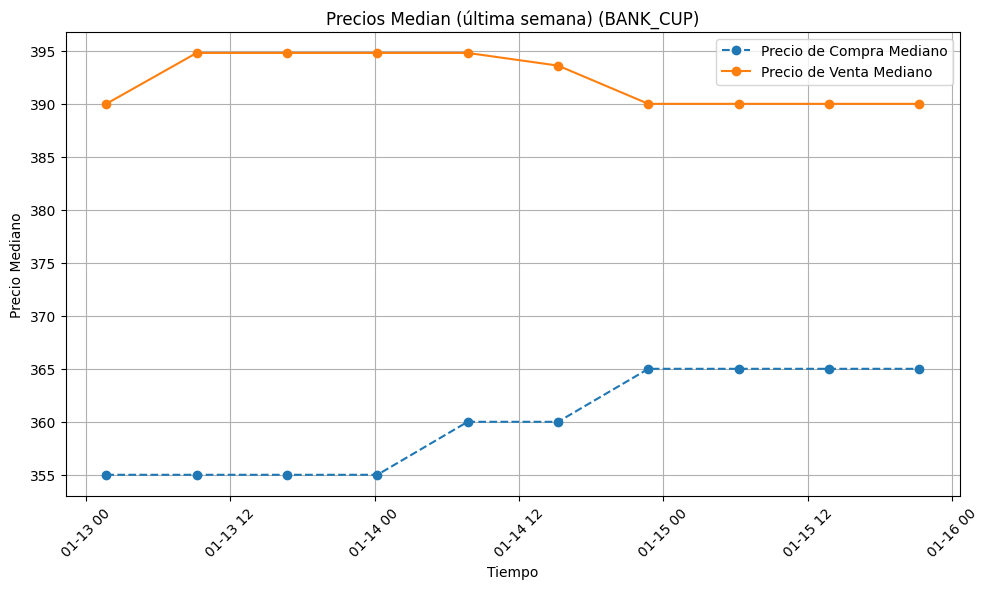

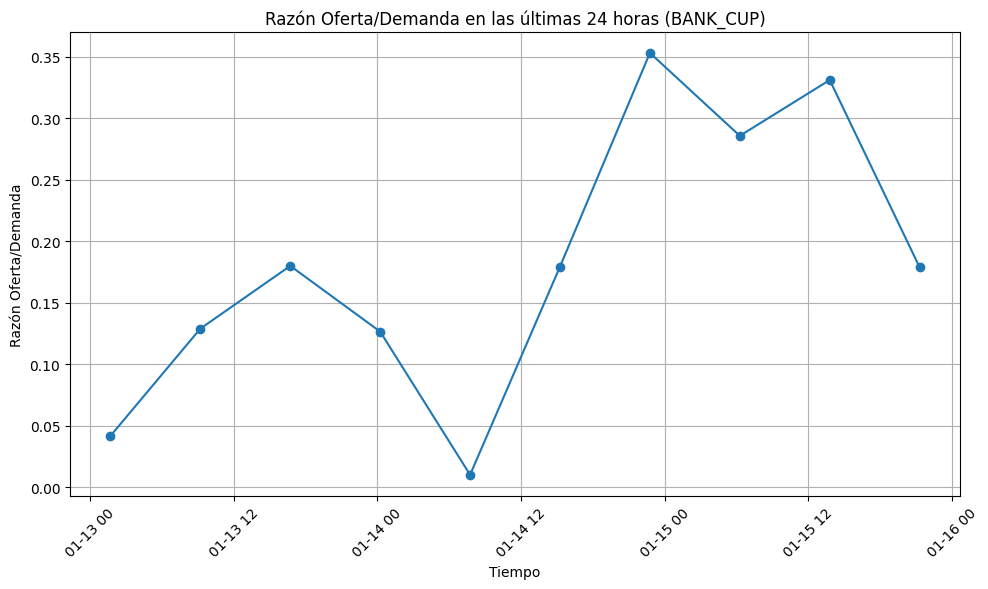

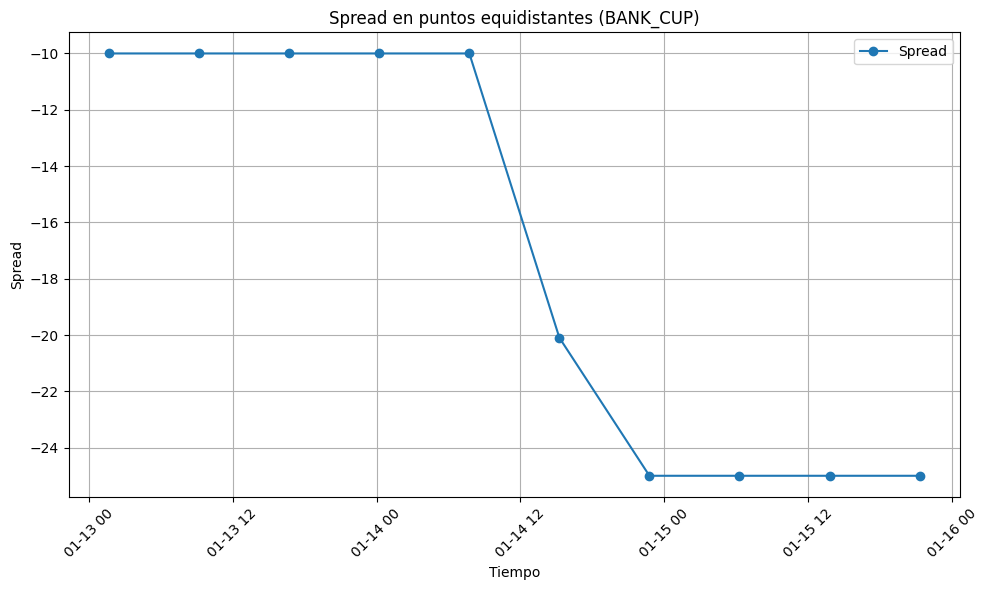

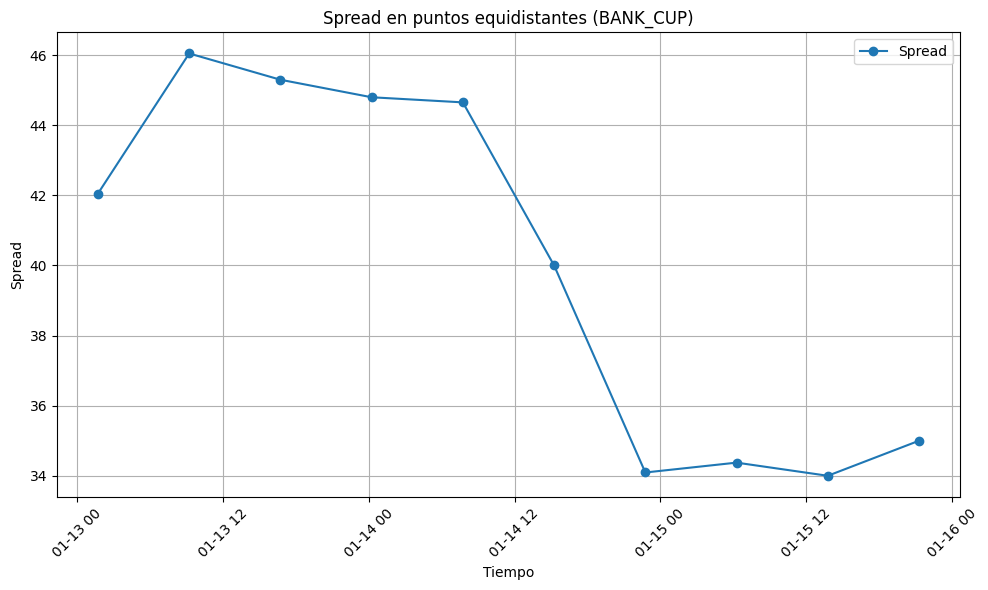

Cluster usando KMeans, devuelve potenciales Market Makers


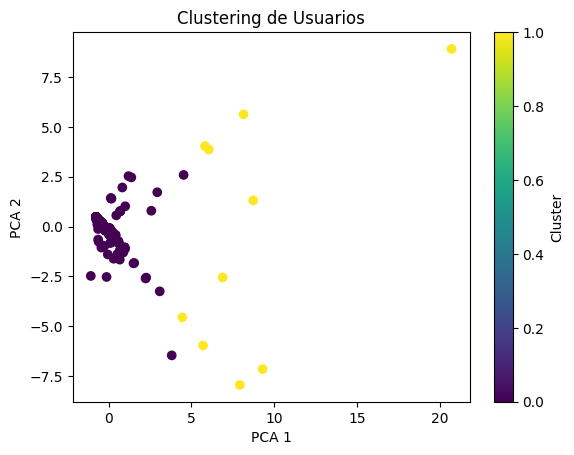

Cluster usando Agglomerative, devuelve potenciales Market Makers


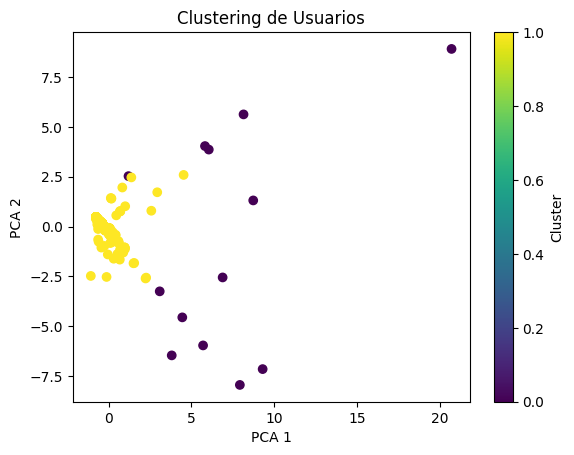

Spread global por cada un de los potenciales Market Makers


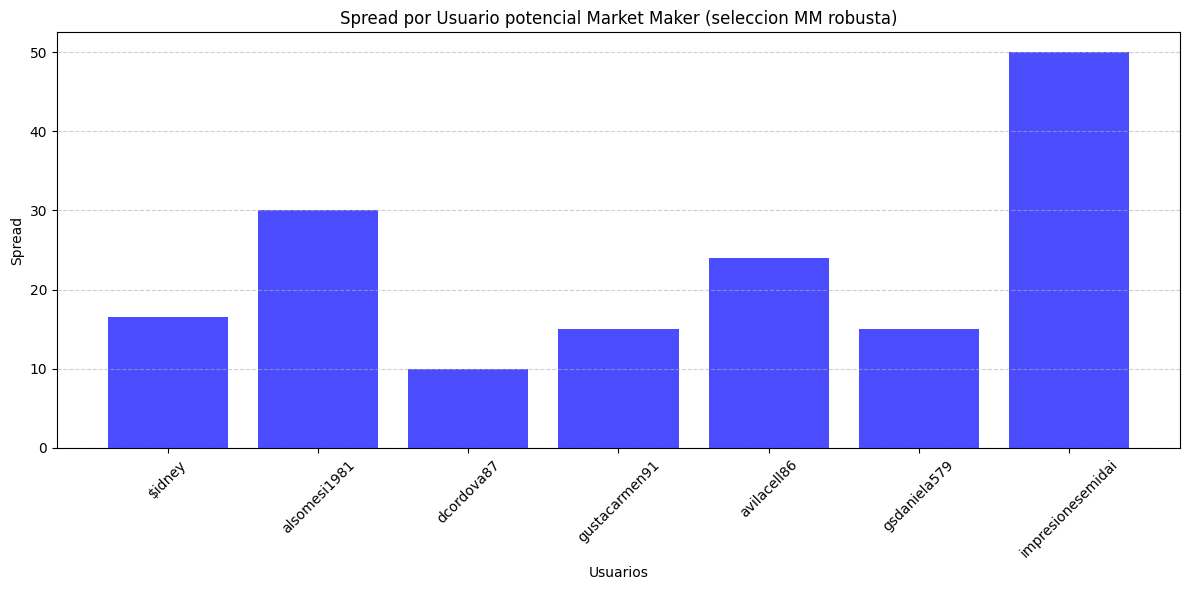

        username  num_ofertas  num_ventas  num_compras  ratio_ventas_compras  \
0         $idney           17          14            3              4.666667   
1   alsomesi1981           11           1           10              0.100000   
2     dcordova87            5           3            2              1.500000   
3  gustacarmen91            9           1            8              0.125000   
4    avilacell86            7           3            4              0.750000   

   precio_de_compra  precio_de_venta     spread  monto_por_vender_USD  \
0        367.777778          384.375  16.597222                191.07   
1        355.000000          385.000  30.000000                 50.00   
2        370.000000          380.000  10.000000                 55.00   
3        370.000000          385.000  15.000000                 20.00   
4        360.000000          384.000  24.000000                120.00   

   monto_por_comprar_USD  evaluacion_del_usuario  vip + kyc  \
0                

In [34]:
coin = input('Inserte moneda para profundizar:')

if coin in list(df['coin']):
    print(datos_de_mercado_x_moneda(df, coin))
    
    try:
        print("Estadísticas esenciales en el tiempo \n")
        graficar_precios_medianos(df, coin)
        graficar_razon_oferta_demanda_24h(df, coin)
        graficar_spread(df, coin)
        graficar_spread_approx(df, coin)
    except:
        print("No hay suficientes datos")
    try:
        new_df = seleccion_de_monedas(df, [coin])
        cluster = kmeans_sobre_mm(new_df, 2)
        print("Cluster usando KMeans, devuelve potenciales Market Makers")
        print_df_mm(cluster[1], cluster[2])
        print("Cluster usando Agglomerative, devuelve potenciales Market Makers")
        print_df_mm(cluster[1], cluster[3])
        print("Spread global por cada un de los potenciales Market Makers")
        graficar_spread_por_usuario_mm_checked(df, coin)
        lista_monedas = [datos_market_maker_analisis(new_df, user) for user in list(market_makers_criterio_combinado(new_df)[1])]
        ddff = pd.DataFrame(lista_monedas)
        print(ddff)
    except:
        print('No hay suficientes datos')


Función para sacar estadísticas del comportamiento de una moneda en un día determinado

In [29]:
dia = input("Día entre 1ro y 15:")
coin = input("Moneda:")
try:
    estadisticas_por_fecha(df,coin, f'2025-01-{dia}')
except:
    print("No hay suficiente data")

{'fecha': '2025-01-13',
 'moneda': 'BANK_CUP',
 'oferta': 151.31,
 'demanda': 1320.0,
 'precio_estimado_venta': 394.80259870064964,
 'precio_estimado_compra': 370.0,
 'menor_precio_venta': 390.0,
 'mayor_precio_compra': 370.0,
 'spread': 20.0}

## Resumen - Conclusiones

Durante el proyecto:

2. Carga y Análisis de datos 
- Exploro las accesibilidades de la API, recogiendo toda la información de las ofertas abiertas, y visibles para la condición Básica de usuario.
- Se identifican usuarios potenciamente Market Makers a partir de contrastar algoritmos de clusterización no supervisados sobre vectores característicos, y trabajando con las caracteristícas usuales de los Market Makers.
- Representamos los gráficos de spread por cada uno de los candidatos a MM por moneda, así como el spread en el tiempo del grupo de MMs de una moneda.
3. Se da una función que permite obtener oferta, demanda, spread, y mediana, media y desviación estandar de los precios de compra y venta por día.
- Sobre la relación de la oferta y la demanda además de gráficos como los que plotean la relación de oferta por demanda, representó desde el inicio una limitación para la extracción de estadísticas certeras. Variables como relacióno ferta/demanda y spread, se ven muy limitadas.
4. Entre los análisis que pudiéramos considera extras están la clusterización, gráficos como el del precio mediana, o los grupos estadísticos.
